# Bar data

In [1]:
from ib_insync import *
util.startLoop()

ib = IB()
ib.connect('127.0.0.1', 7497, clientId=14)

## Historical data

To get the earliest date of available bar data the "head timestamp" can be requested:

In [2]:
contract = Stock('TSLA', 'SMART', 'USD')

ib.reqHeadTimeStamp(contract, whatToShow='TRADES', useRTH=True)

datetime.datetime(2010, 6, 29, 8, 0)

To request hourly data of the last 60 trading days:

In [3]:
bars = ib.reqHistoricalData(
        contract,
        endDateTime='',
        durationStr='60 D',
        barSizeSetting='1 hour',
        whatToShow='TRADES',
        useRTH=True,
        formatDate=1)

In [4]:
bars[0]

BarData(date=datetime.datetime(2017, 5, 11, 15, 30), open=323.89, high=326.0, low=320.41, close=321.57, volume=9650, barCount=4569, average=323.12)

Convert the list of bars to a data frame and print the first and last rows:

In [5]:
df = util.df(bars)

display(df.head())
display(df.tail())

,date,open,high,low,close,volume,barCount,average
0,2017-05-11 15:30:00,323.89,326.00,320.41,321.57,9650,4569,323.120
1,2017-05-11 16:00:00,321.86,322.75,319.60,322.16,8408,4694,321.183
2,2017-05-11 17:00:00,322.16,323.70,321.86,322.61,4608,2697,322.683
3,2017-05-11 18:00:00,322.62,323.29,322.29,323.03,1848,1181,322.812
4,2017-05-11 19:00:00,323.01,324.71,322.86,323.56,3616,1945,323.914


,date,open,high,low,close,volume,barCount,average
412,2017-08-04 17:00:00,349.30,352.66,348.85,351.10,14453,6944,351.394
413,2017-08-04 18:00:00,351.08,352.05,350.12,351.24,5779,2950,351.172
414,2017-08-04 19:00:00,351.21,354.25,351.21,353.77,8654,4227,353.043
415,2017-08-04 20:00:00,353.73,353.92,351.51,352.71,6808,3374,352.905
416,2017-08-04 21:00:00,352.57,357.27,352.40,357.00,17463,10263,355.045


Instruct the notebook to draw plot graphics inline:

In [6]:
%matplotlib inline

Plot the close data

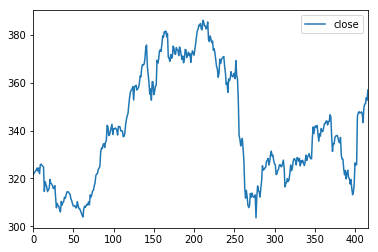

In [7]:
df.plot(y='close');

There is also a utility function to plot bars as a candlestick plot. It can accept either a DataFrame or a list of bars. Here it will print the last 100 bars:

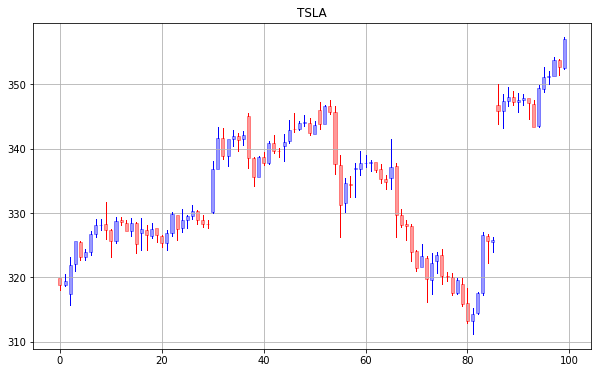

In [8]:
util.barplot(bars[-100:], title=contract.symbol);

## Historical data with realtime updates

A new feature of the API is to get live updates for historical bars. This is done by setting `endDateTime` to an empty string and the `keepUpToDate` parameter to `True`.

Let's get some bars with an keepUpToDate subscription:

In [9]:
contract = Forex('EURUSD')

bars = ib.reqHistoricalData(
        contract,
        endDateTime='',
        durationStr='3600 S',
        barSizeSetting='1 min',
        whatToShow='MIDPOINT',
        useRTH=True,
        formatDate=1,
        keepUpToDate=True)

Replot for every change of the last bar:

(interupt the loop with "Kernel interupt" button or menu item)

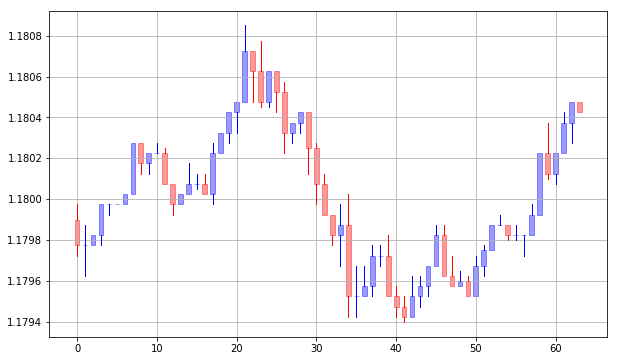

In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

prevBar = None
while ib.waitOnUpdate():
    currBar = bars[-1] if bars else None
    if prevBar != currBar:
        prevBar = currBar
        plt.close()
        plot = util.barplot(bars)
        clear_output(wait=True)
        display(plot)